# Assignment 4: Permutation test 1
## Learning Outcomes
By completing this assignment, you will be able to implement and use randomization tests to determine whether a specific effect is statistically significant. Randomization tests are a highly universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 

## Problem Description
An increasingly common statistical tool for determining whether a difference is significant is the randomization or permutation test. A randomization test builds - rather than assumes – a sampling distribution of the test statistics. This is achieved by exchanging or permuting variables which are “exchangeable” under the Null-hypothesis. A randomization test gives a simple way to compute the sampling distribution for any test statistic under the null hypothesis that the dependent variable is statistically not dependent on the shuffled variable. 
In this assignment, we continue with the income dataset from week 1 and 2. This week your main task is to determine whether the difference in proportion for female vs. male directors to direct action movies is significant. 
You are allowed to use standard numpy and pandas functions such as mean, groupby, shuffle. But you are not allowed to use a permutation functions that have been already been designed. Numeric calculations in python that are printed should be rounded to 6 decimal places. 

Methods that you may find beneficial. 
Pandas: crosstab, iloc. Numpy: random.shuffle, reset_index, matplotlib: hist, axvline 

## The dataset 
As a data scientist for a Hollywood law firm, your task is to provide evidence for the claim that there is gender discrimination in the movie industry. You are provided with a summary of the last 250 movies, and the gender and income of the director. The dataset also includes a number of other variables
- North American box office revenue (boxoff)
- Production cost of the movie (prodcost)
- Income of the director (dirIncome in millions)
- Gender of the director (dirGender) 
- Year of release (year)
- Month of release (month) 
- Movie genre (genre): Action, Comedy 
- Number of theatres (numTheatrs)


## Preliminaries 
Import pandas, numpy, matplotlib, and load the dataset file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

df = pd.read_csv("movieDataset.csv")

## TASK 1: Defining the test statistics (40pts)
### Question 1  - Explore the gender imbalance across movie genres (10pts)
As you did in Assignment 02, create a table that displays the number of movies per genre and director gender. Make a stacked barplot that best let's you see what proprtion of directors were female for each movie genre.   Remember x-, y-axis labels and caption. Written answer: Which movie genre has the highest proportion of female directors? 

*Hint: Since this is a new dataset for you, it is excellent practice to explore the dataset as you did in Assignment number 2*

dirGender,female,male
genre,,
action,0.157895,0.842105
adventure,0.093750,0.906250
comedy,0.270833,0.729167
drama,0.138889,0.861111
other,0.088889,0.911111


Text(0, 0.5, 'Frequency')

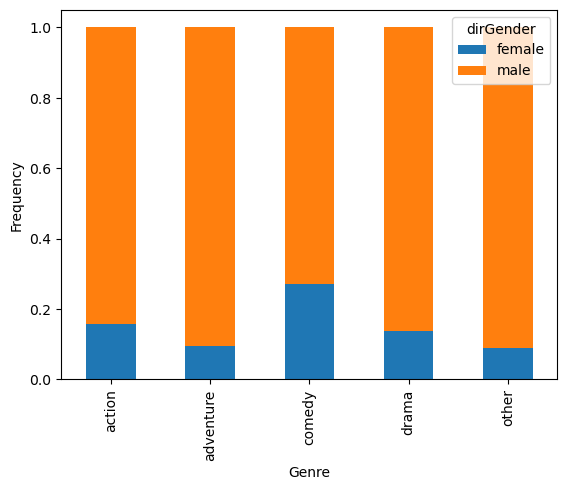

In [2]:
table = pd.crosstab(df['genre'], df['dirGender'], margins = False, normalize = "index")
display(table)

g = table.plot(kind = "bar", stacked = True)
g.set_xlabel("Genre")
g.set_ylabel("Frequency")


Figure 1. Stacked bar plot showing the relative proportions of male and female directors by genre. 

Written answer: The genre with the highest proportion of female directors is comedy.

### Question 2 - Create contingency table of comedy (yes/no) by director gender (5pts)
Generate and display a cross-tabulation table of the 2x2 proportions of directorGender vs. whether the movie is a comedy or not (all other genres should be combined into non-comedy movies).  

In [3]:
table2 = pd.crosstab(df["genre"] == "comedy", df["dirGender"], margins = True)
display(table2)

dirGender,female,male,All
genre,,,
False,24,178,202
True,13,35,48
All,37,213,250


### Question 2 - Calculate p(comedy|female)-p(comedy|male) (15pts)
Calculate and report the probability that the movie is a comedy given that the director Gender is female, p(comedy|female), the probability of the movie is a comedy given that the director Gender is male, p(comedy|male), as well as the difference between these two numbers, p(comedy|female)- p(comedy|male) (for help, see solution to homework 2).

In [4]:
# Conditional Probability P(A given B) = P(A and B) / P(B)
# comedy given female

cpCaF = ((table2.iloc[1]["female"]/table2.iloc[2]["All"]) / (table2.iloc[2]["female"]/table2.iloc[2]["All"]))

print(f"Probability that the movie is a comedy given female, is {cpCaF:.6f}")

Probability that the movie is a comedy given female, is 0.351351


In [5]:
cpCaM = ((table2.iloc[1]["male"]/table2.iloc[2]["All"]) / (table2.iloc[2]["male"]/table2.iloc[2]["All"]))

print(f"Probability that the movie is a comedy given male, is {cpCaM:.6f}")

Probability that the movie is a comedy given male, is 0.164319


In [6]:
diff = cpCaF - cpCaM

print(f"The difference between p(comedy|female) - p(comedy|male) is, {diff:.6f}")

The difference between p(comedy|female) - p(comedy|male) is, 0.187032


### Question 3 - Define a function that calculates this difference in probability (10pts)
Write a function (e.g., https://www.tutorialspoint.com/python/python_functions.htm) that takes the data frame as an input and returns the difference on conditional probabilities (as calculated in question 2). 
Test the function by calling it with your data and report the difference in probability 
This difference is your test statistics for the coming permutation test.

In [7]:
def probDiff(D):
    probs = []
        
    funcTable = pd.crosstab(D["genre"] == "comedy", D["dirGender"], margins = True)
    probs.append(((funcTable.iloc[1]["female"]/funcTable.iloc[2]["All"]) / (funcTable.iloc[2]["female"]/funcTable.iloc[2]["All"])))
    probs.append(((funcTable.iloc[1]["male"]/funcTable.iloc[2]["All"]) / (funcTable.iloc[2]["male"]/funcTable.iloc[2]["All"])))
    
    difference = probs[0] - probs[1]
    
    return difference

In [8]:
print(f"The difference in probability between p(comedy|female) - p(comedy|male) is, {probDiff(df):.6f}")

The difference in probability between p(comedy|female) - p(comedy|male) is, 0.187032


## Task 2: Perform a permutation test (60pts)
### Question 1 (10pts)
Written answer: We want to test the hypothesis that female directors are more likely than male directors to conduct a comedy. Under this hypothesis the p(comedy|female) should be higher than p(comedy|male). What is the Null-hypothesis we need to consider? 

Null hypothesis: p(comedy|male) >= p(comedy|female)
Alternative hypothesis: p(comedy|female) > p(comedy|male)

### Question 2 (40pts)
Perform a permutation test. Under the Null-hypothesis the director gender is exchangeable. 

First, write a function that takes the data frame as an input and then randomly permutes the a specific columns that data frame (see lab for hints).

Then write a function ``permutation_test`` that takes a data frame as an input and the loops ``numIter`` times. Every iteration of the  the loop it should shuffle the dirGender column of the data and then calls the function written for Task1, Q3 to get the test statistic. Each iteration, the test statistic should  be stored in a list.  

After building up the numpy array of test statistics, the function should plot a histogram of the test statistics and mark the value of the empirical test statistics by a vertical line (see https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.axvline.html). Finally, it should report the p-value. 

For Pseudo code see lecture. Start with 500 iterations to test your code – for the final result, use 5000 iterations.

In [9]:

def permutation_test(frame, numIter):
    sample = np.array([])
    
    for i in range(0, numIter):
        df_copy = frame.copy()
        idx = df_copy.index

        idx_arr = np.arange(0, len(idx))

        np.random.shuffle(idx_arr)

        shuffled_gender = df_copy["dirGender"].iloc[idx_arr]

        shuffled_gender_id = shuffled_gender.reset_index(drop = True)
        shuffled_gender_id

        df_copy["dirGender"] = shuffled_gender_id

        sample = np.append(sample, probDiff(df_copy))
        
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
    axes.hist(sample, bins = 50, color = 'b')
    axes.set_xlabel("Female - Male comedies")
    axes.set_ylabel("Number of Observations")
    plt.axvline(x = probDiff(frame), color = 'r')

        
    return sample


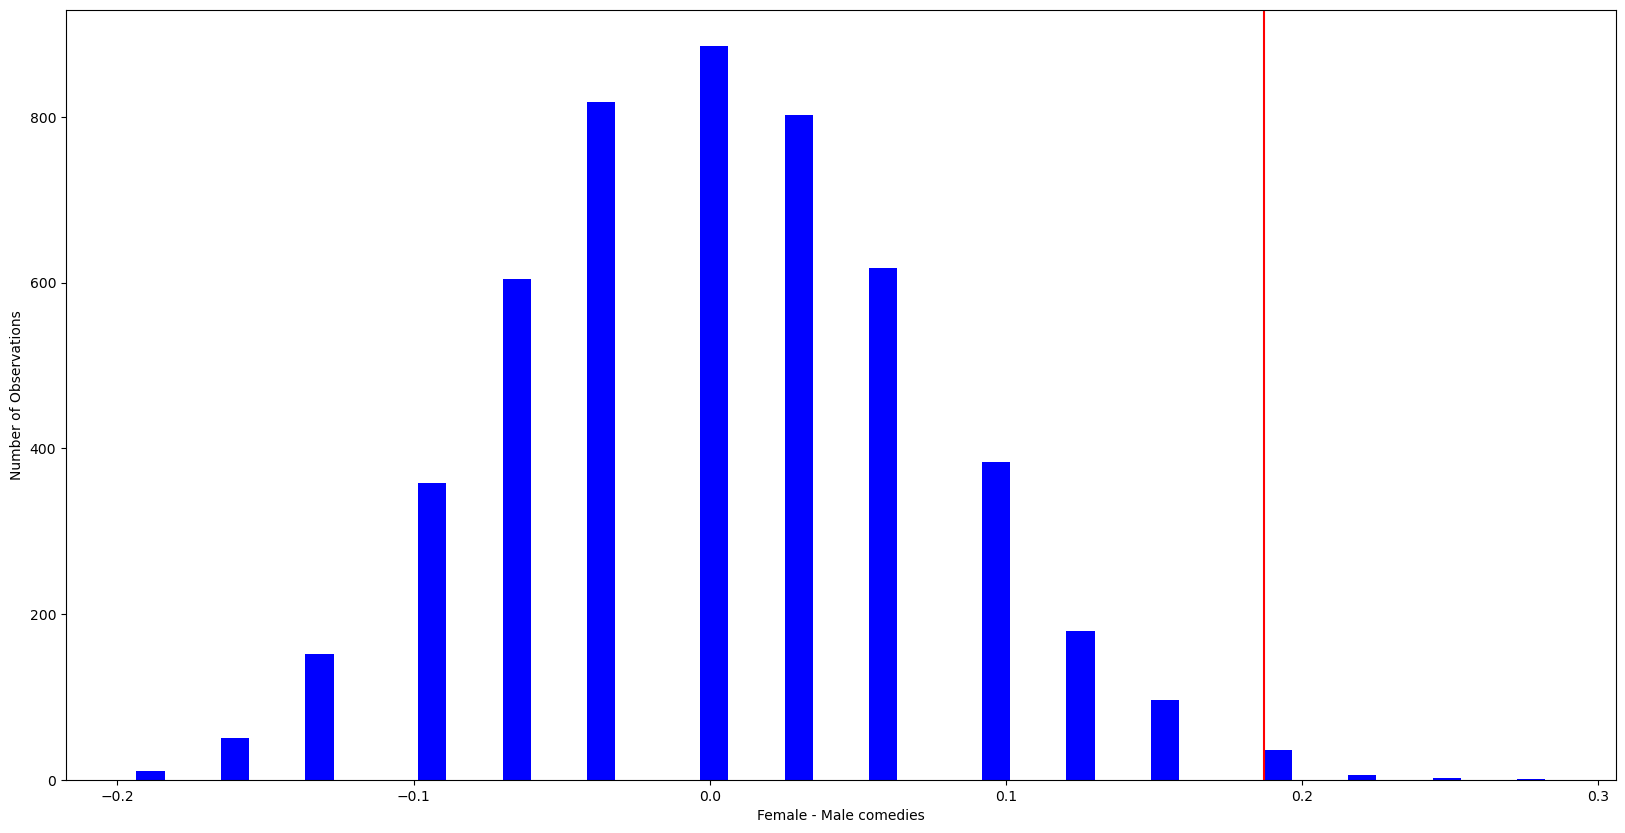

In [10]:
sampleData = permutation_test(df, 5000)

In [11]:
a = sampleData >= diff
p = sum(a) / 5000
print(f"The p-value is {p}")


# Personal Note:
# What is the probability by chance we get the value 
# of >= to p(comedy|female) - p(comedy|male) in 5000 randomizations

The p-value is 0.009


### Question 3 (10pts)
Written response: What do you conclude from this result?

I can conclude that the data provided convincing evidence for the alternative hypothesis that women are more likely to direct a comedy than men, therefore we reject the null hypothesis that men are greater or equally likely to direct a comedy.